In [251]:
import pandas as pd
from ast import literal_eval
import numpy as np
import re

import geolocate

from importlib import reload
reload(geolocate)

<module 'geolocate' from '/Users/dan/code/metis_projects/1_airbnb_pricing/geolocate.py'>

In [177]:
bodega_data = pd.read_csv("./data/bodegas.csv")

bodega_data.columns = bodega_data.columns.str.replace(" ", "_").str.lower().str.strip()

bodega_data.city = bodega_data.city.str.replace("#","").str.lower().str.strip()

bodega_data.drop(columns=[
    "square_footage", "county", "state",
    "license_number", "counties", "new_york_zip_codes",
    "address_line_2", "address_line_3"
], inplace=True)


In [178]:
bodega_data.loc[bodega_data.city == "brookyln", "city"] = "brooklyn"
bodega_data.loc[bodega_data.city == "new york", "city"] = "manhattan"
bodega_data.loc[bodega_data.city == "new york city", "city"] = "manhattan"

bodega_data = bodega_data[
    ( bodega_data.city == "brooklyn") | 
    ( bodega_data.city == "manhattan" )
]


In [179]:
len(bodega_data[bodega_data.location.isnull()])


29

In [180]:
bodega_data.dropna(subset=["location"], inplace = True)
len(bodega_data[bodega_data.location.isnull()])


0

In [229]:
np.nan

nan

In [231]:
np.isnan(1)

False

In [300]:
work_latitudes = []
work_longitudes = []

work_addresses = []

for cur_row in bodega_data.itertuples():
    work_dict = literal_eval(cur_row.location)
    
    work_latitude = np.nan
    work_longitude = np.nan
    
    if "latitude" in work_dict and "longitude" in work_dict:
        work_latitude = float(work_dict["latitude"])
        work_longitude = float(work_dict["longitude"])
        
    if not ( np.isnan(work_latitude) or np.isnan(work_longitude) ):
        work_latitudes.append(work_latitude)
        work_longitudes.append(work_longitude)
        continue
    
    work_latitudes.append( np.nan )
    work_longitudes.append( np.nan )

    work_address = f"{cur_row.street_number} {cur_row.street_name} {cur_row.city}, new york {cur_row.zip_code}"
    work_address = re.sub(r'\s+', " ", work_address.strip()).title()

    work_addresses.append(work_address)
        

In [264]:
fixed_latitudes = []
fixed_longitudes = []

for work_address in work_addresses:
    fixed_latitude, fixed_longitude = geolocate.gc(work_address)
    
    fixed_latitudes.append(fixed_latitude)
    fixed_longitudes.append(fixed_longitude)


geocoded: 1201 Ave U Brooklyn, New York 11229 (bing - 0.6s)
geocoded: 4209 Avenue D Brooklyn, New York 11203 (openmapquest - 0.5s)
geocoded: 3043 Avenue V Brooklyn, New York 11229 (nominatim - 0.7s)
geocoded: 7818 New Utrecht Brooklyn, New York 11214 (bing - 0.5s)
geocoded: 105-04 Flatlands Ave Brooklyn, New York 11236 (nominatim - 0.8s)
geocoded: 1237 Avenue U Brooklyn, New York 11229 (nominatim - 0.7s)
geocoded: 104-04 Flatlands Ave Brooklyn, New York 11236 (nominatim - 0.8s)
geocoded: 2972 Avenue X Brooklyn, New York 11235 (nominatim - 0.8s)
geocoded: 730 Avenue U Brooklyn, New York 11223 (nominatim - 0.7s)
geocoded: 4624 Avenue D Brooklyn, New York 11203 (openmapquest - 0.3s)
geocoded: 1066 Rutland Rd Store Frt 1 Brooklyn, New York 11212 (arcgis - 0.5s)
geocoded: 357 Avenue X Brooklyn, New York 11223 (openmapquest - 0.5s)
geocoded: 4513 Ave D Brooklyn, New York 11203 (arcgis - 0.4s)
geocoded: 1624 Avenue M Brooklyn, New York 11230 (openmapquest - 0.9s)
geocoded: 195-197 Havermeyer 

geocoded: 498 Ave Of The Americas Manhattan, New York 10011 (arcgis - 0.5s)
geocoded: 600-602 W 207Th St Manhattan, New York 10034 (openmapquest - 0.4s)
geocoded: 1370 Avenue Of The Americas Manhattan, New York 10019 (bing - 0.7s)
geocoded: 2520-2526 Broadway Manhattan, New York 10025 (arcgis - 0.4s)
geocoded: 2 Penn Plz Manhattan, New York 10119 (arcgis - 0.4s)
geocoded: 2760-62 Broadway Manhattan, New York 10025 (bing - 0.5s)
geocoded: 125-133 3Rd Ave Manhattan, New York 10003 (openmapquest - 0.3s)
geocoded: 1251 Avenue Of The Americans Manhattan, New York 10020 (bing - 0.5s)
geocoded: 250 W 57Th St Manhattan, New York 10019 (bing - 0.5s)
geocoded: 1052-1056 1St Ave Manhattan, New York 10022 (openmapquest - 0.3s)
geocoded: 1627-1629 Broadway Manhattan, New York 10019 (bing - 0.5s)
geocoded: 4 World Trade Center Manhattan, New York 10007 (nominatim - 0.7s)
geocoded: 1321 St Nicholas Ave Manhattan, New York 10033 (nominatim - 0.7s)
geocoded: 10 Hudson Sq /160 Varick Street Manhattan, N

In [320]:
nan_latitudes = list(np.where(np.isnan(work_latitudes))[0])
nan_longitudes = list(np.where(np.isnan(work_longitudes))[0])

assert nan_latitudes == nan_longitudes

assert len(nan_latitudes) == len(work_addresses)
assert len(nan_longitudes) == len(work_addresses)

assert len(fixed_latitudes) == len(work_addresses)
assert len(fixed_longitudes) == len(work_addresses)

for fixed_index, nan_index in enumerate(nan_latitudes):
    work_latitudes[nan_index] = fixed_latitudes[fixed_index]
    work_longitudes[nan_index] = fixed_longitudes[fixed_index]


In [337]:
bodega_data["latitude"] = work_latitudes
bodega_data["longitude"] = work_longitudes

bodega_data.entity_name = bodega_data.entity_name.str.title()
bodega_data.city = bodega_data.city.str.title()

bodega_data.sort_values(by=["city", "entity_name"], inplace=True)

bodega_data.drop(columns=[
    "location", "street_number", "street_name", "zip_code", "dba_name", "operation_type"
], inplace=True)


In [367]:
bodega_data = bodega_data[bodega_data.latitude > 40]
bodega_data = bodega_data[bodega_data.latitude < 40.9]


In [364]:
import matplotlib.pyplot as plt

In [366]:
bodega_data[bodega_data.latitude > 40.9]

,establishment_type,entity_name,city,latitude,longitude
15069,JAC,Zuniga Luis Enrique&Suquinagua Ca,Manhattan,40.908252,-73.848811


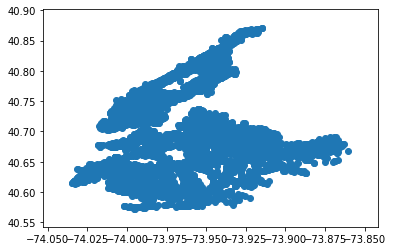

In [368]:
plt.scatter(bodega_data.longitude, bodega_data.latitude)

In [371]:
len(bodega_data)

7806

In [372]:
bodega_data.to_pickle("./data/pickles/bodega_data.pkl")
